In [1]:
# Import libraries and define helper functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

def build_dqr_table(df, columns, csv_filename):
    """
    Build and save a Data Quality Report table.
    """
    stats = df[columns].describe().T
    perc_missing = 100 * (df[columns].isnull().sum() / len(df))
    cardinality = df[columns].nunique()
    
    dqr_table = pd.concat([
        stats,
        pd.DataFrame(perc_missing, columns=['%missing']),
        pd.DataFrame(cardinality, columns=['cardinality'])
    ], axis=1)
    
    dqr_table.to_csv(csv_filename, index_label='Feature')
    return dqr_table

print("Helper function loaded successfully\n")

Helper function loaded successfully



In [2]:
# Data Cleaning and Type Conversion

df_train = pd.read_csv("ppr-group-25209033-train.csv")
df_test = pd.read_csv("ppr-group-25209033-test.csv")


# Convert Date
df_train['Date of Sale (dd/mm/yyyy)'] = pd.to_datetime(df_train['Date of Sale (dd/mm/yyyy)'], format='%d/%m/%Y')

# Clean Price and convert to numeric
if 'Price (€)' in df_train.columns:
    df_train['Price (€)'] = df_train['Price (€)'].astype(str).str.replace('€', '', regex=False).str.replace(',', '', regex=False)
    df_train['Price'] = pd.to_numeric(df_train['Price (€)'])
    df_train = df_train.drop(columns=['Price (€)'])

# Binary encoding for Yes/No
binary_map = {'Yes': 1, 'No': 0}
df_train['Not Full Market Price'] = df_train['Not Full Market Price'].map(binary_map)
df_train['VAT Exclusive'] = df_train['VAT Exclusive'].map(binary_map)

# Convert specific columns to 'category' type
categorical_cols = ['County', 'Description of Property', 'Property Size Description']
for col in categorical_cols:
    df_train[col] = df_train[col].astype('category')

# Clean duplicate rows
duplicate_count = df_train.duplicated().sum()
if duplicate_count > 0:
    df_train = df_train.drop_duplicates()
    print(f"Dropped {duplicate_count} duplicate rows.")

# Clean constant columns
constant_columns = [col for col in df_train.columns if df_train[col].nunique() <= 1]
if constant_columns:
    df_train = df_train.drop(columns=constant_columns)
    print(f"Dropped constant columns: {constant_columns}")
    
df_train.info()
print("\n")

print("Type conversion and cleaning complete. Current shape:", df_train.shape)

Dropped 11 duplicate rows.
<class 'pandas.DataFrame'>
Index: 53989 entries, 0 to 53999
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date of Sale (dd/mm/yyyy)  53989 non-null  datetime64[us]
 1   Address                    53989 non-null  str           
 2   County                     53989 non-null  category      
 3   Eircode                    16843 non-null  str           
 4   Not Full Market Price      53989 non-null  int64         
 5   VAT Exclusive              53989 non-null  int64         
 6   Description of Property    53989 non-null  category      
 7   Property Size Description  2829 non-null   category      
 8   Price                      53989 non-null  float64       
dtypes: category(3), datetime64[us](1), float64(1), int64(2), str(2)
memory usage: 3.0 MB


Type conversion and cleaning complete. Current shape: (53989, 9)


In [3]:
# Save the cleaned dataset
cleaned_filename = 'ppr-group-25209033-train-cleaned.csv'
df_train.to_csv(cleaned_filename, index=False)
print(f"Cleaned dataset saved as {cleaned_filename}")

Cleaned dataset saved as ppr-group-25209033-train-cleaned.csv


In [4]:
# Generate DQR Tables

continuous_features = ['Price']
categorical_features = ['Address', 'County', 'Eircode', 'Not Full Market Price', 
                        'VAT Exclusive', 'Description of Property', 'Property Size Description']

# Continuous Features DQR Table
print("--- Continuous Features DQR Table ---")
dqr_continuous = build_dqr_table(df_train, continuous_features, 'dqr_continuous_features.csv')
display(dqr_continuous)

# Categorical Features DQR Table
print("\n--- Categorical Features DQR Table ---")

df_cat_display = df_train[categorical_features].copy()

inv_map = {1: 'Yes', 0: 'No'}
df_cat_display['Not Full Market Price'] = df_cat_display['Not Full Market Price'].map(inv_map)
df_cat_display['VAT Exclusive'] = df_cat_display['VAT Exclusive'].map(inv_map)

df_cat_display = df_cat_display.astype('category')

dqr_categorical = build_dqr_table(df_cat_display, categorical_features, 'dqr_categorical_features.csv')
display(dqr_categorical)

print("DQR Tables generated.")

--- Continuous Features DQR Table ---


,count,mean,std,min,25%,50%,75%,max,%missing,cardinality
Price,53989.0,333738.789755,2.129882e+06,5250.0,156000.0,250000.0,365000.0,387665198.0,0.0,6655



--- Categorical Features DQR Table ---


,count,unique,top,freq,%missing,cardinality
Address,53989,53347,"FALLEIGHTER, AGHAMORE, BALLYHAUNIS",4,0.000000,53347
County,53989,26,Dublin,16569,0.000000,26
Eircode,16843,16789,D24W9NN,4,68.802904,16789
Not Full Market Price,53989,2,No,51077,0.000000,2
VAT Exclusive,53989,2,No,44391,0.000000,2
Description of Property,53989,2,Second-Hand Dwelling house /Apartment,44246,0.000000,2
Property Size Description,2829,4,greater than or equal to 38 sq metres and less...,2137,94.760044,4


DQR Tables generated.


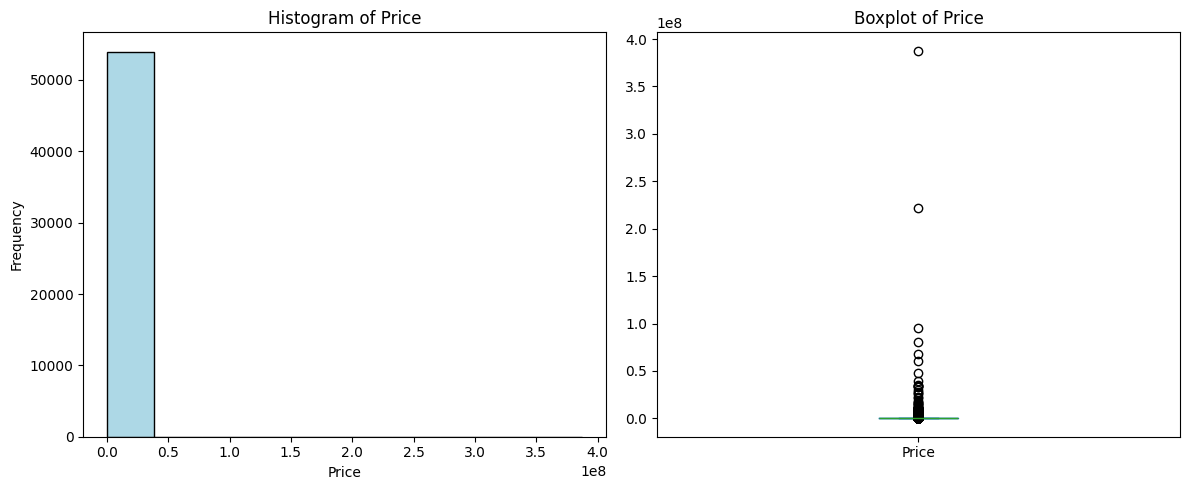

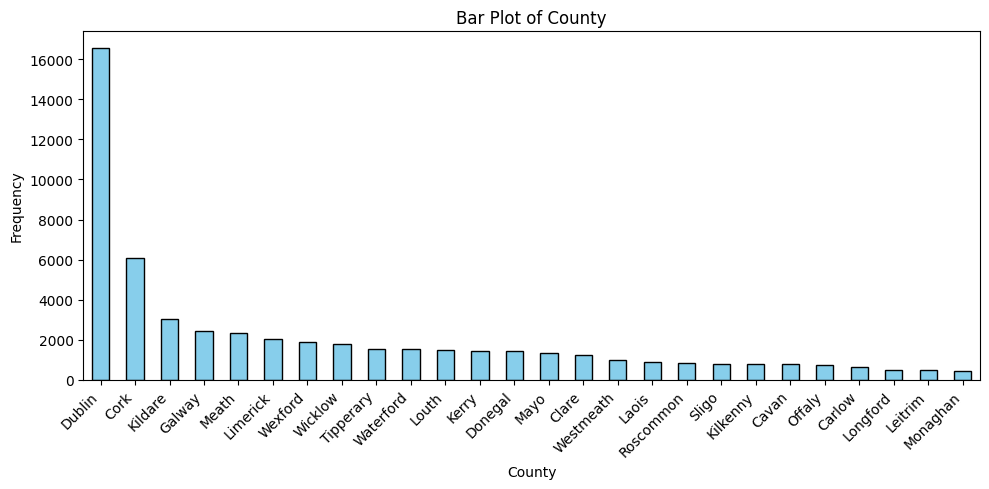

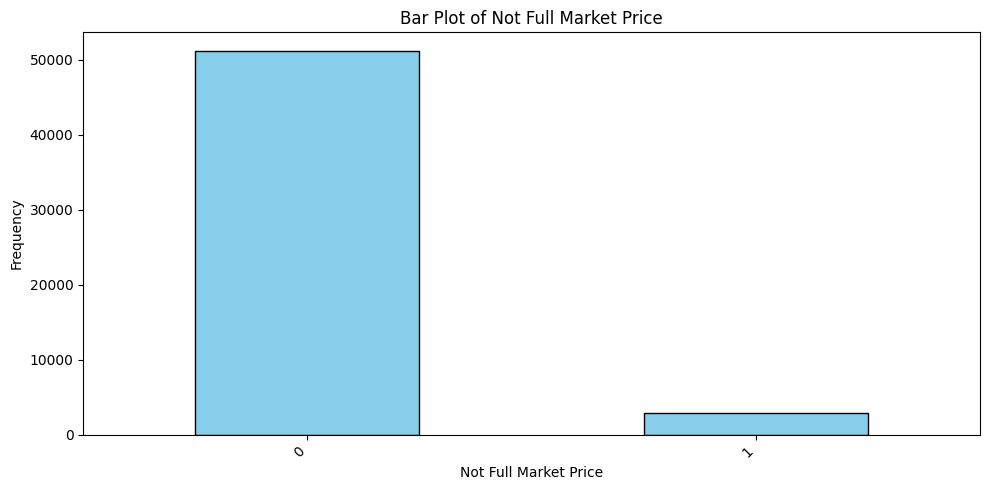

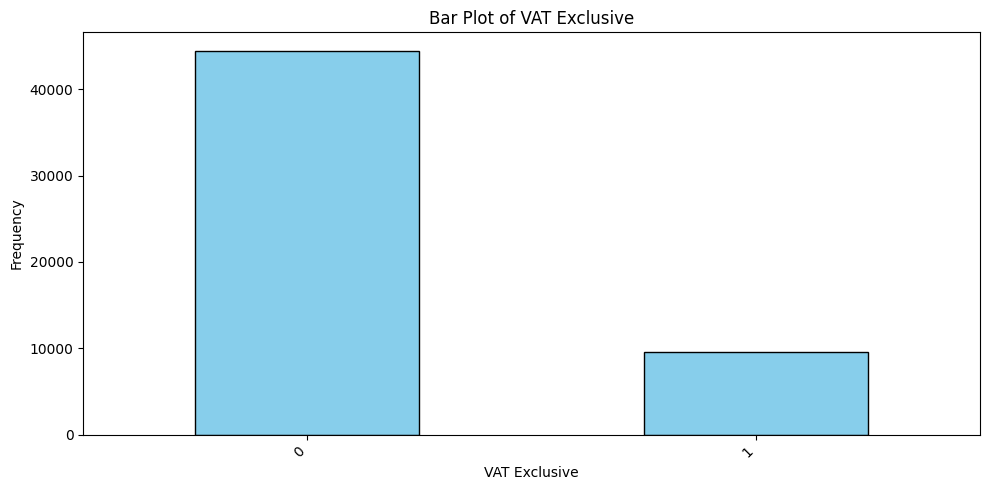

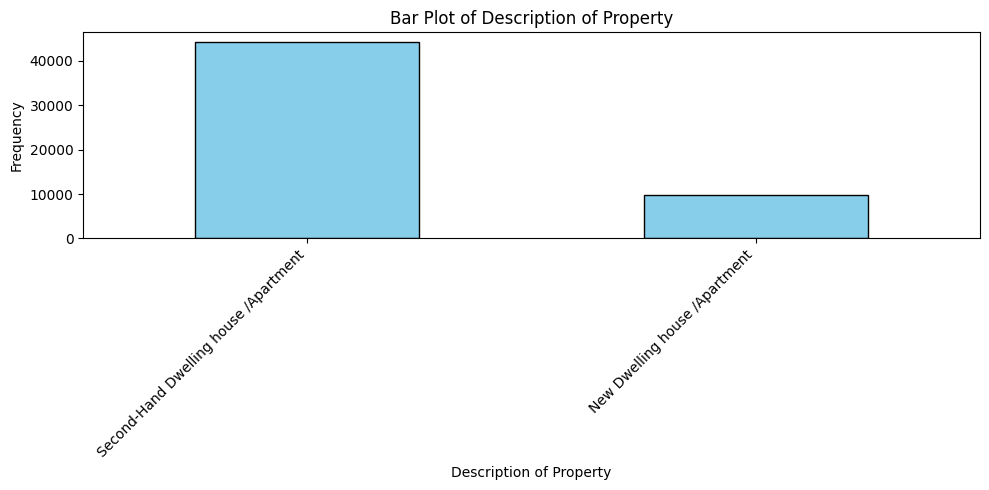

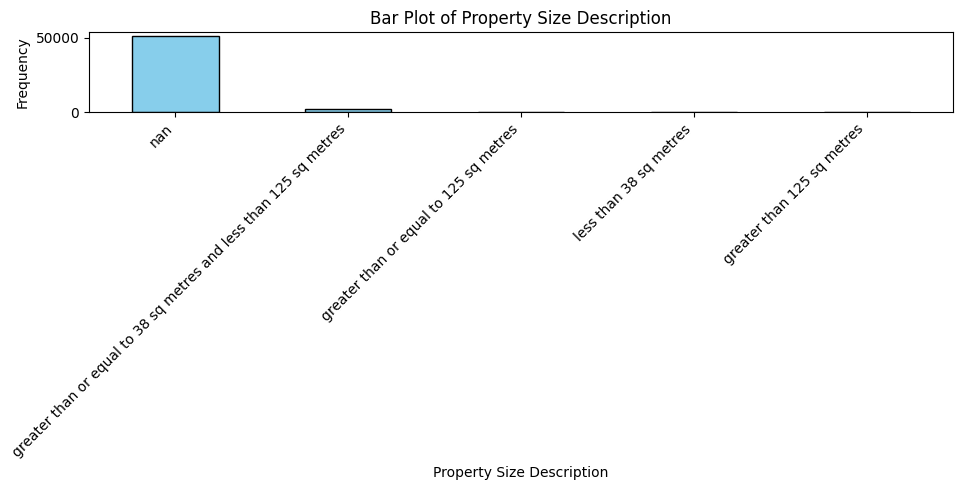

Plots generated and saved in 'dqr_plots' folder.


In [5]:
# Generate and save plots for all features (Pandas Built-in Plotting)

os.makedirs('dqr_plots', exist_ok=True)

categorical_features_to_plot = ['County', 'Not Full Market Price', 'VAT Exclusive', 
                                'Description of Property', 'Property Size Description']

# Plot Continuous Features
for col in continuous_features:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Histogram
    df_train[col].plot(kind='hist', ax=axes[0], title=f'Histogram of {col}', color='lightblue', edgecolor='black')
    axes[0].set_xlabel(col)
    
    # Boxplot
    df_train[col].plot(kind='box', ax=axes[1], title=f'Boxplot of {col}')
    
    plt.tight_layout()
    plt.savefig(f'dqr_plots/{col}_plot.png')
    plt.show()

# Plot Categorical Features
for col in categorical_features_to_plot:
    plt.figure(figsize=(10, 5))
    
    counts = df_train[col].value_counts(dropna=False)
    
    # Bar plot
    counts.plot(kind='bar', title=f'Bar Plot of {col}', color='skyblue', edgecolor='black')
    
    plt.ylabel('Frequency')
    plt.xlabel(col)
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig(f'dqr_plots/{col}_barplot.png')
    plt.show()

print("Plots generated and saved in 'dqr_plots' folder.")